<center>
    <h3>University of Toronto</h3>
    <h3>Department of Mechanical and Industrial Engineering</h3>
    <h3>MIE368 Analytics in Action </h3>
    <h3>(Fall 2020)</h3>
    <hr>
    <h1>Lab 5: Model Engineering</h1>
    <h3>October 28, 2020</h3>
</center>



# Introduction

We have implemented several different models throughout this course and  discussed when one is more appropriate than the other. However, often times in practice there are no clear guidelines on how to develop the best model for an application. Suppose we want to build a binary classifier with high recall and precision. How should we proceed if our off-the-shelf model performs poorly on the dataset?

In this lab, we will explore a series of techniques for improving your model and features. We will cover seven techniques:

- **Model selection**: We can try several different models to see what works best.
- **Scaling**: The scale of the values in your data is important
- **Feature engineering**: If the existing features aren't useful then we can create new and more relevant features   
- **Feature section**: If you have too many features then we can remove some that aren't useful
- **Grid Search**: a process for finding a set of good hyper-parameters (e.g., regularization strength)
- **Model stacking**: a process where the output from one or more models are input into another.
- **Bagging**: a process for combining models that involves combining the outputs from multiple models.

Model engineering is more of an art than it is a science. These techniques will work better in some instances than they do in others, and sometimes these techniques can actually make a model perform worse! When you do model engineering it really boils does to doing trial-and-error with these techniques. It is possible to combine these techniques (e.g., do model selection, scaling, and grid search), however, to stop this lab from becoming convoluted you will only combine each technique with model selection.

Please keep in mind that these are just a set of possible ways to improve our models. There are many ways to engineer better models, and often the practice of model engineering comes down to the application and our prior experience. We emphasis that in this lab we will largely apply these techniques in isolation, but we encourage you to combine multiple techniques in your project.

## Application
This lab will focus on the lending industry, where investors provide loans to borrowers in exchange for the promise of repayment with interest. If the borrower repays the loan, then the lender profits from the interest. However, sometimes the borrower is unable to repay the loan, meaning the lender loses money. The lender in this problem wants to predict if a borrower is unlikely to repay a loan and has asked us to build the best possible prediction model.

First, let us import the essential tools.

In [6]:
# Standard analytics packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
# Import models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# Model evaluation 
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV
# Import model engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

Next, we'll load the dataset for this lab and store it as `df_raw`.

In [7]:
# Import data for lab
df_raw = pd.read_csv("https://docs.google.com/uc?export=download&id=1zj7qSc5mjgXLjQgOfF60PsbO2wupLnTm")
df_raw.head()

,CreditPolicy,Purpose,IntRate,Installment,Dti,Fico,DaysWithCrLine,RevolBal,RevolUtil,InqLast6mths,Delinq2yrs,PubRec,NotFullyPaid,AnnualInc
0,1,debt_consolidation,0.1189,829.10,19.48,737,5639.958333,28854,52.1,0,0,0,0,85000.000385
1,1,credit_card,0.1071,228.22,14.29,707,2760.000000,33623,76.7,0,0,0,0,65000.000073
2,1,debt_consolidation,0.1357,366.86,11.63,682,4710.000000,3511,25.6,1,0,0,0,31999.999943
3,1,debt_consolidation,0.1008,162.34,8.10,712,2699.958333,33667,73.2,1,0,0,0,85000.000385
4,1,credit_card,0.1426,102.92,14.97,667,4066.000000,4740,39.5,0,1,0,0,80799.999636


The data if `df_raw` is described in the following data dictionary:

|Columns         |Definition                               |
|:--------------:|:----------------------------------------|
|**Features**    |  |
|CreditPolicy    |1 if the borrower meets the underwriting criteria                       |
|Purpose         |Written purpose of the loan                           |    
|IntRate         |Assigned interest rate                           |
|Installment     |Monthly installments                      |  
|Dti             |Borrower's debt to income ratio               |
|Fico            |Borrower's FICO (credit) score                    |
|DaysWithCrLine  |Number of days the borrower has had an existing line of credit                 |
|RevolBal        |Revolving balance (current unpaid credit-card debt)            |
|RevolUtil       |Revolving line utilization (fraction of line of credit used)                 |
|InqLast5mths    |Number of inquiries by creditors in last 5 months            |
|Delinq2yrs      |Number of times the borrower has been 30+days past due in last 2 years                         |
|PubReq          |Number of derogatory public records                    |
|AnnualInc       |Self-reported annual income of borrower         |
|**Target**      |                                 |
|NotFullyPaid    |1 if the loan was not fully paid back                       |


# Exploratory data analysis and cleaning
In this section, we'll quickly clean the data so that all categorical information is encoded as a series of binary values and then we'll do some brief exploratory data analysis (EDA) to better understand the data. 

## Data Cleaning
Note that the dataset is already quite clean (e.g., no missing values). The only real issue with it right now is that the "Purpose" column in `df_raw` is categorical. Let's encode the information into a series of binary variables. Note, that encoding values as zeros and ones is often called _one-hot encoding_ in the anaytics community, however, it also goes by _making dummy variables_ in the statistics community. We will use the term one-hot encoding to be consistent with the analytics community, however, `pandas` (and some other popular packages) use the term "dummies". 

In [8]:
'''Convert categorical data into "dummy" variables'''
df = pd.get_dummies(df_raw, columns=['Purpose']) 
df.head()

,CreditPolicy,IntRate,Installment,Dti,Fico,DaysWithCrLine,RevolBal,RevolUtil,InqLast6mths,Delinq2yrs,PubRec,NotFullyPaid,AnnualInc,Purpose_all_other,Purpose_credit_card,Purpose_debt_consolidation,Purpose_educational,Purpose_home_improvement,Purpose_major_purchase,Purpose_small_business
0,1,0.1189,829.10,19.48,737,5639.958333,28854,52.1,0,0,0,0,85000.000385,0,0,1,0,0,0,0
1,1,0.1071,228.22,14.29,707,2760.000000,33623,76.7,0,0,0,0,65000.000073,0,1,0,0,0,0,0
2,1,0.1357,366.86,11.63,682,4710.000000,3511,25.6,1,0,0,0,31999.999943,0,0,1,0,0,0,0
3,1,0.1008,162.34,8.10,712,2699.958333,33667,73.2,1,0,0,0,85000.000385,0,0,1,0,0,0,0
4,1,0.1426,102.92,14.97,667,4066.000000,4740,39.5,0,1,0,0,80799.999636,0,1,0,0,0,0,0


Throughout this lab we use a training set (i.e., `X_train` and `y_train`) and validation set (e.g., `X_val` and `y_val`).


In [9]:
'''Make training and validation dataset that we'll use throughout the lab'''
# Split the data
X_train, X_val, y_train, y_val = train_test_split(df.drop(columns=['NotFullyPaid']),
                                                    df.NotFullyPaid,
                                                    test_size = 0.3,
                                                    random_state = 1)


# Make a dataframe for the training data 
df_train = X_train.join(y_train)

We can analyze `X_train` and `y_train` as much as we want when designing or optimizing a model. However, you should avoid doing EDA on your validation or testing set (i.e., out-of-sample data) to avoid _data leakage_. Data leakage occurs when information from your out-of-sample data is incorporated into your models (often unintentionally). In general, you perform EDA to guide your modeling decisions, so if your out-of-sample data is included in your EDA then it may influence your modeling decisions.

## EDA
Use the data frame `df_train` to do all your EDA to ensure their is no data leakage. 

We can use the `describe()` method on a data frame to print out a summary of the columns. Use the output of `describe()` or write your own code where appropriate to answer the following questions.

### Exercises

1. Apply the `describe()` method to `df_train`.

In [10]:
# Write your code here.  
# -------------------

df_train_describe = df_train.describe()
df_train_describe

# -------------------

,CreditPolicy,IntRate,Installment,Dti,Fico,DaysWithCrLine,RevolBal,RevolUtil,InqLast6mths,Delinq2yrs,PubRec,AnnualInc,Purpose_all_other,Purpose_credit_card,Purpose_debt_consolidation,Purpose_educational,Purpose_home_improvement,Purpose_major_purchase,Purpose_small_business,NotFullyPaid
count,6704.000000,6704.000000,6704.000000,6704.000000,6704.000000,6704.000000,6.704000e+03,6704.000000,6704.000000,6704.000000,6704.000000,6.704000e+03,6704.000000,6704.000000,6704.000000,6704.000000,6704.000000,6704.000000,6704.000000,6704.000000
mean,0.801014,0.122590,319.644112,12.609300,710.907369,4557.635889,1.694455e+04,46.708816,1.602327,0.159755,0.062351,6.832708e+04,0.243586,0.131265,0.410949,0.037739,0.065185,0.045943,0.065334,0.157518
std,0.399267,0.027047,206.869072,6.882637,38.010970,2501.947628,3.532676e+04,29.055547,2.184938,0.524771,0.262517,6.229470e+04,0.429278,0.337715,0.492043,0.190578,0.246870,0.209377,0.247133,0.364316
min,0.000000,0.060000,15.670000,0.000000,612.000000,180.041667,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.896000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103300,164.020000,7.250000,682.000000,2819.958333,3.152250e+03,22.600000,0.000000,0.000000,0.000000,3.840000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.530000,12.600000,707.000000,4110.041667,8.546500e+03,46.100000,1.000000,0.000000,0.000000,5.518800e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.141100,434.867500,17.940000,737.000000,5730.041667,1.808175e+04,70.700000,2.000000,0.000000,0.000000,8.000000e+04,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,922.420000,29.950000,827.000000,17616.000000,1.207359e+06,119.000000,33.000000,11.000000,4.000000,2.039784e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


2. What proportion of borrows default on their loans?

In [11]:
# Write your code here.  
# -------------------

df_train_describe.NotFullyPaid.loc['mean']

# -------------------

0.1575178997613365

3. Which of the purposes for borrowing is most likely to lead to a default?

In [12]:
# Write your code here.  
# -------------------

summary_df = df_train.groupby('NotFullyPaid').sum()
summary_fraction_df = summary_df.loc[1]/summary_df.loc[0]
summary_fraction_df.idxmax()

# -------------------

'Purpose_small_business'

4. Which of the purposes has the highest correlation with the `NotFullyPaid` variable?


In [13]:
# Write your code here.  
# -------------------

correlation_vector = df_train.corr().NotFullyPaid.drop('NotFullyPaid')
correlation_vector.abs().idxmax()
# -------------------

'CreditPolicy'

# Tracking progress

Throughout this lab we make several models. In this section we will initialize a function `make_models` and a data frame `all_models` that we will use throughout the lab. 

## Defining the `make_models` function

We will apply the seven techniques in this lab using four different models, which are initialized in the `make_models` function below.

* _LR_L2_: is a logistic regression with an L2 loss
* _LR_L1_: is a logistic regression with an L1 loss with "balanced" class weights
* _CART_: is a CART tree with with "balanced" class weights
* _RF_: is a random forest with with "balanced" class weights




In [14]:
def make_models():
  """Makes a dictionary of four untrained models"""
  
  return {
      'LR_L2': LogisticRegression(random_state=0),
      'LR_L1': LogisticRegression(random_state=0, penalty='l1', solver='liblinear', class_weight='balanced'),
      'CART': DecisionTreeClassifier(random_state=0, class_weight='balanced'),
      'RF': RandomForestClassifier(random_state=0, class_weight='balanced'),
  }


### Exercise

> 1. Notice that we set the parameter `class_weights` to `'balanced'`. Look up the documentation for `LogisticRegression`. What does the `class_weights = 'balanced'` do? Why do you think its appropriate here?
>> "balanced" class weights will adjust the weights of the target values to make them inversely proportional to class frequencies in the training data as n_samples / (n_classes * np.bincount(y). For example, in this dataset where 16% of targets are 1, predicting each 0 correctly gets 0.16 the reward of predicting 1 correctly. This helps to fight the imbalance in the dataset

## Initializing the `all_models` data frame

In the code block below we initialize the `all_models` data frame. You don't need to understand every line of code, the more important this is to understand that we have a data fram called `all_models` that we will use throughout this lab to track progress.

In [15]:
'''Create a data frame to keep track of all the models we train in this lab'''

# Initialize a tuple of names for each model
model_names = ('LR_L2',  # Logistic regression with L2 regularizer
               'LR_L1',  # Logistic regression with L1 regularizer
               'CART',  # Cart tree classifier
               'RF'  # Random forest classifier 
               )
# Initialize a tuple of techniqu names that we will cover
engineering_techniques = ('Baseline',  # Set of baseline models
                          'Scaling',  # Set of models trained with scaled data
                          'Feature Engineering',  # Set of models trained with engineered features
                          'Feature_Selection',  # Set of models trained with "selected" features
                          'Grid Search',  # Set of models trained via grid search
                          'Stacking',  # Set of stacked model 
                          'Bagging'  # A bagged model
                          )

# Initialize the multi indices of the `all_models` data frame
df_indices = pd.MultiIndex.from_product([model_names, engineering_techniques], names=('model names', 'technique'))
# Initialize the `all_models` data frame
all_models = pd.DataFrame(index=df_indices, columns=['Precision', 'Recall', 'Score', 'Model'])
all_models[['Precision', 'Recall', 'Score']] = all_models[['Precision', 'Recall', 'Score']].astype(float)
all_models  # Initialized data frame only has NaNs, which is perfect!

Precision  Recall  Score Model
model names technique                                          
LR_L2       Baseline                   NaN     NaN    NaN   NaN
            Scaling                    NaN     NaN    NaN   NaN
            Feature Engineering        NaN     NaN    NaN   NaN
            Feature_Selection          NaN     NaN    NaN   NaN
            Grid Search                NaN     NaN    NaN   NaN
            Stacking                   NaN     NaN    NaN   NaN
            Bagging                    NaN     NaN    NaN   NaN
LR_L1       Baseline                   NaN     NaN    NaN   NaN
            Scaling                    NaN     NaN    NaN   NaN
            Feature Engineering        NaN     NaN    NaN   NaN
            Feature_Selection          NaN     NaN    NaN   NaN
            Grid Search                NaN     NaN    NaN   NaN
            Stacking                   NaN     NaN    NaN   NaN
            Bagging                    NaN     NaN    NaN   NaN
CART        Baseline                   NaN     NaN    NaN   NaN
            Scaling                    NaN     NaN    NaN   NaN
            Feature Engineering        NaN     NaN    NaN   NaN
            Feature_Selection          NaN     NaN    NaN   NaN
            Grid Search                NaN     NaN    NaN   NaN
            Stacking                   NaN     NaN    NaN   NaN
            Bagging                    NaN     NaN    NaN   NaN
RF          Baseline                   NaN     NaN    NaN   NaN
            Scaling                    NaN     NaN    NaN   NaN
            Feature Engineering        NaN     NaN    NaN   NaN
            Feature_Selection          NaN     NaN    NaN   NaN
            Grid Search                NaN     NaN    NaN   NaN
            Stacking                   NaN     NaN    NaN   NaN
            Bagging                    NaN     NaN    NaN   NaN

We're initialized a data frame `all_models`. Over the course of this lab, we will replace the NaNs in this data frame. 

# Model selection (Baseline)

For starters, we should fit our four baseline models. We will score each model using its average precision and recall (i.e., $\frac{precision + recall}{2}$). We covered precision and recall in lab one, but you can refer to [this article](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall) for a refresher.

### Exercise

> 1. Complete the function below, which fits multiple models on a training dataset, and evaluates its precision, recall, and the average of precision and recall on the out-of-sample data. You should use the `precision_score()` and `recall_score()` functions below to calculate those metrics.

In [16]:
# from sklearn.metrics import precision_score, recall_score

def fit_and_score_model(all_models, stage_name, X_train, X_out_of_sample, y_train, y_out_of_sample):
    """Fits the models that are inialized by models_dict on the X_train and y_train
    data, and evalautes the model on the out-of-sample data X_out_of_sample and y_out_of_sample"""
    
    # Make a dictionary of models
    models_dict = make_models()

    # Loop through each model in model_dict
    for model_name in models_dict:
        model = models_dict[model_name]
        
        '''Write some code to fit the model, and calculate precision (call it 
        model_precision), recall (call it model_recall), and score (call it 
        model_score) on the validation set.'''
        

        # Write your code here.  
        # -------------------------------------------------------------------------
    
        model.fit(X_train, y_train)  # fit the model
    
        model_precision = precision_score(y_out_of_sample, model.predict(X_out_of_sample))  # evaluate precision on test set
        model_recall = recall_score(y_out_of_sample, model.predict(X_out_of_sample))  # evaluate recall on test set
        model_score = (model_precision + model_recall) / 2
        
        # -------------------------------------------------------------------------
        print(f'{model_name} achieved a precision of {model_precision:.3f} and recall of {model_recall:.3f}')
        
        all_models.loc[model_name, stage_name] = (model_precision, model_recall, model_score, model)

    return all_models
    
all_models = fit_and_score_model(all_models, 'Baseline', X_train, X_val, y_train, y_val)
all_models.loc[:, 'Baseline', :].head()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LR_L2 achieved a precision of 0.000 and recall of 0.000
LR_L1 achieved a precision of 0.257 and recall of 0.579
CART achieved a precision of 0.199 and recall of 0.203
RF achieved a precision of 0.167 and recall of 0.002


,Precision,Recall,Score,Model
model names,,,,
LR_L2,0.000000,0.000000,0.000000,"LogisticRegression(C=1.0, class_weight=None, d..."
LR_L1,0.256506,0.578616,0.417561,"LogisticRegression(C=1.0, class_weight='balanc..."
CART,0.199179,0.203354,0.201266,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
RF,0.166667,0.002096,0.084382,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."


Upon examining the `all_models` data frame, you should see that it keep tracks of the precision, recall, and a score (float types) in addition to the trained models (object type). You should also see that the baseline "LR_L2" model is very bad, but the other models looks a little more promising. 

### Exercises



> 1. We provided some code that will use the baseline LR_L2 model to predict target values. Describe those predictions. Does anything seem strange? (**Hint**: you should see an `UndefinedMetricWarning` after running the previous code block that mentions 'zero\_division'.)

In [17]:
# Predict the target values using the logistic regression model
y_val_predictions = all_models.Model.loc['LR_L2','Baseline'].predict(X_val)

# Write your code here
# -------------------------------------------------------------------------

y_val_predictions.mean()
# All predictions are zero

# -------------------------------------------------------------------------

0.0

> 2. Why should we use precision and recall as our metrics for this problem rather than the usual ROC metrics?

>> Precision and recall are better suited for imbalanced target data. Precision and recall can measure rare events much better than ROC metrics because they evaluate true positive, false positive, and false negative events, whereas ROC only looks at false positive and true positive. 

In the rest of this lab we will develop the best possible classifier to improve the score of each using one technique at a time (on these 4 baseline models). We will build and train our models on the training set and evaluate on the validation set.

# Data scaling
Next, lets scale the features to have a mean of zero and standard deviation of one (i.e., standardize). This is a very important step when features have different orders of magnitude. However, when features values have similar orders of magnitude (like they do now) you may see little to no improvement. The easiest way to standardize data is with the `StandardScaler` function, which is "fit" (i.e., calculates the mean and standard deviation) on the training set. Once trained, you should apply it to both the training and validation set before fitting and scoring your model. Note, that we can generally keep binary data ''as is''. Since our target data (whether or not a loan was repaid) is binary, we won't scale the target, which makes the data scaling step a little easier. However, if the target data was a continuous variable, then we could follow the same steps that we will go through with our feature data to scale the target data. 

### Exercise

> 1. Complete the function `standardize_data` that initializes a `StandardScaler`, fits it on a training dataset (`X_train`). Use the fit `scaler` to to standardize (i.e., transform) the training and out-of-sample data (`X_val`), and call the variables `X_train_standarized` and `X_out_of_sample_standarized`, respectively.)

In [18]:
# from sklearn.preprocessing import StandardScaler

technique_name = 'Scaling'

def standardize_data(X_train, X_out_of_sample):
    """Standardizes all of the data in X_train and X_out_of_sample. The mean and
    standard diviation of each feature (i.e., each column) from the X_train
    data is used to standarize both the X_train and X_out_of sample."""

    # Initialize data frame for scaled data
    X_train_standarized = X_train.copy()
    X_out_of_sample_standarized = X_out_of_sample.copy()

    # Define scaling function
    scaler = StandardScaler()
    
    '''Use scaler to standardize your data. You'll need to fit scaler with your
    training data (use the fit method) and standardize your training and 
    out-of-sample data (use the transform method)'''
    # -------------------------------------------------------------------------

    # Scale the X features      
    scaler.fit(X_train)
    X_train_standarized.loc[:]  = scaler.transform(X_train)
    X_out_of_sample_standarized.loc[:] = scaler.transform(X_out_of_sample)
                        
    # -------------------------------------------------------------------------

    return X_train_standarized, X_out_of_sample_standarized, scaler

# Make new data that is scaled"
X_train_scaled, X_val_scaled, scaler = standardize_data(X_train, X_val)

# Fit and score a model trained with scaled data
all_models = fit_and_score_model(all_models, technique_name, X_train_scaled, X_val_scaled, y_train, y_val)
all_models.loc[:, technique_name, :].head()

LR_L2 achieved a precision of 0.471 and recall of 0.017
LR_L1 achieved a precision of 0.257 and recall of 0.587
CART achieved a precision of 0.200 and recall of 0.203
RF achieved a precision of 0.167 and recall of 0.002


,Precision,Recall,Score,Model
model names,,,,
LR_L2,0.470588,0.016771,0.243680,"LogisticRegression(C=1.0, class_weight=None, d..."
LR_L1,0.257353,0.587002,0.422178,"LogisticRegression(C=1.0, class_weight='balanc..."
CART,0.200000,0.203354,0.201677,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
RF,0.166667,0.002096,0.084382,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."


## Defining the compare_models function

Lets define the function `compare_models` to compare the models based on the technique `technique_name` to the "Baseline" models

In [19]:
def compare_models(technique_name):
  """Prints out the average and biggest improvement observed between the 
  models trained with technique_name and the Baseline models"""

  # Evaluate score differences
  score_differences = (all_models.loc[:, technique_name, :].Score - all_models.loc[:, 'Baseline', :].Score)

  # Get the average and biggest score improvement
  mean_score_difference = score_differences.mean()
  most_score_improvement = score_differences.max()

  print(f'On average, scores improved by {mean_score_difference:.2f}, and the most improvement was {most_score_improvement:.2f}')

compare_models(technique_name)

On average, scores improved by 0.06, and the most improvement was 0.24


## Using a fit standardization method
If you want to convert your features (or target variables if they were scaled) back into the units from the original features, then you can use the `inverse_transform` method as we do below. Note, that the mean of the transformed training set should always be zero, but the mean of the out-of-sample set will likely just be close to zero because the standardization is based on the training set mean and standard deviation (using the testing set is cheating!). Below is just an example of how to run a quick sanity check to ensure the scaling is working properly.

In [20]:
# Transform the data back to original units
transformed_X_train = scaler.inverse_transform(X_train_scaled)
transformed_X_val = scaler.inverse_transform(X_val_scaled)

# Evaluate the average of each data set
print(f'The mean of the scaled feature in column 0 is {X_train_scaled.iloc[:, 0].mean():.3f} and {X_val_scaled.iloc[:, 0].mean():.3f} for training and validation, respectively.')
print(f'The mean of the un-scaled feature in column 0 is {transformed_X_train[:, 0].mean():.3f} and {transformed_X_val[:,0].mean():.3f} for training and validation, respectively.')

The mean of the scaled feature in column 0 is 0.000 and 0.033 for training and validation, respectively.
The mean of the un-scaled feature in column 0 is 0.801 and 0.814 for training and validation, respectively.


### Exercises

> 1. You should see that the mean of the first feature in `X_train_scaled` is 0, but its mean in `X_val_scaled` is  0.033. Why isn't the mean of `X_val_scaled` 0 after we've standardized it?

>> Standardization is based on the mean and standard deviation of the training set. If the validation set has a different mean or standard deviation then it won't have mean 0 and standard deviation 1 (although it should be close!).


# Feature Engineering

In this section, we will see that our dataset has many features that are not useful for predicting the target. When this is the case, you should try to collect better data, however, when better data in unavailable we must do the best with what we have. One option is to create new, strong features that are more useful for predicting the target by transforming and combining weak features (like we did in Lab 1!). This practice is known as feature engineering.

Generally, good features have several desirable characteristics, for example, they:
*   are spread out evenly (e.g., Gaussian or uniform distributions)
*   behave differently (e.g., they may have different means) when the target is different
*   are normalized to similar scales.

One common technique is to apply logarithms or square roots to features with very large values that follow a distribution with a long tail (e.g., population, income). The problem with distributions that have large values and long tails is that the absolute change in the value of a feature gives less information than the relative change. For example, a 100 dollar difference in income means very different things if you are comparing two low income data points versus two high income data points.

We can also "combine" features (e.g., add them, multiply them) to make them more useful. When we combine features we can take advantage of *interaction effects* (a concept from statistics), where the interaction of two features together is greater than the sum of the parts. For example, if two features correlate strongly with a target, it is likely that the product of the two features will also correlate. 

Constructing good features requires experience, domain expertise, and some luck. If you have domain knowledge about your application then you should  think about whether a transformation or a new feature makes sense for the problem, and you should always check that your engineered features are useful for predicting a target. You can generally do anything to create new features. The common tricks include multiplying and/or dividing multiple existing features, however, there are two major rules related to feature engineering:

1. Do not create too many features, especially in order to chase marginal increases in correlation. If the correlation is small and your dataset is small, you might be creating fake (dataset-dependent) correlations that wont generalize outside of your data.
2. You **cannot** use the target variable to create a feature.

## Transforming your data to get better features

In this lab, we will only do feature engineering by exploiting interaction effects between multiple features. The best way to go about this is by domain knowledge and developed intuition, however, there are also some tricks to make features without domain knowledge, which will be the focus of this section. 

An algorithmic way to generate features is provided in the code block below. Where we loop through every pair of features, and multiply them features together (i.e., "combine" them). We then evaluate the _usefulness_ of the combined features. There are many metrics for feature selection ([see list of `sklearn` functions here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)). We will use the function `f_classif` to evaluate the  **An**alysis **o**f **Va**riance (ANOVA) F-Value, which is appropriate for estimating how useful a feature is for predicting a categorical target. A higher F-value suggests the feature will be better, and a $p$-value $<$ 0.05 suggests the F-value returned is based on a real trends in the data (i.e., not random chance). 

For more detail on the ANOVA F-Value you can refer to[this article](https://machinelearningmastery.com/feature-selection-with-numerical-input-data/#:~:text=ANOVA%20f%2Dtest%20Feature%20Selection,-ANOVA%20is%20an&text=The%20ANOVA%20method%20is%20a,as%20an%20ANOVA%20f%2Dtest.&text=The%20results%20of%20this%20test,be%20removed%20from%20the%20dataset). However, please keep in mind that `f_classif` should only be used when the target is categorical. As a result, you should use other tests if the target is continuous. 

**Note:** The code block below uses a 'magic command' ([more info here](https://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=capture#cellmagic-capture )) to suppress warning messages that would normally come up when running `f_classif` in this example. Those warnings can be safely ignored, and this magic command provides and easy way to hide them :)  


In [21]:
%%capture --no-stdout  
# from sklearn.feature_selection import f_classif
# Create a list of F-values for the existing features
feature_F_scores, _ = f_classif(X_train, y_train)

# Iterate through each combination of features
for f1_index, f1 in enumerate(X_train.columns):
  for f2_index, f2 in enumerate(X_train.columns[f1_index + 1:]):
    # Multiply the two features to create a new feature
    new_feature = X_train[[f1]].multiply(X_train[f2], axis=0)
    # Evaluate F-value of new feature
    F_Score_new, p_value_new = f_classif(new_feature, y_train)
    # Evaluate the relative improvement of the new feature
    F_score_improvement = F_Score_new[0]/max(feature_F_scores[[f1_index, f2_index]])
    # Print out features that is sufficiently improved 
    if F_score_improvement >= 1.5 and F_Score_new[0] >= 75 and p_value_new < 0.05:
        '''Note that F_score_improvement >= 1.5 and F_Score_new[0] >= 75 is
         relatively arbitrary, and that other values could be used.'''
        print(f'{f1} + {f2} has an F-score of {F_Score_new[0]:.2f}')
        print(f'\tBetter by a factor of {F_score_improvement:.2f} over features in isolation')
        print(f'\tThe result is significant (p = {p_value_new})')


Installment + InqLast6mths has an F-score of 134.11
	Better by a factor of 8.57 over features in isolation
	The result is significant (p = [1.01107633e-30])
DaysWithCrLine + InqLast6mths has an F-score of 96.81
	Better by a factor of 6.18 over features in isolation
	The result is significant (p = [1.08827276e-22])


### Exercise

> 1. Play around with the above code and the space below to see if you can find any new interesting or useful features. For example, you could try different transforms of the features, or combining three features together. Oftentimes, this task of feature engineering is the most important and time consuming aspect of machine learning. Good features are hard to come by!

>> You can try changing the function we use to combine features, adjusting the various threshold defined in the final id statement

## Using transformed features to train a model

It is important to not get too carried away with algorithmic feature engineering. If we construct a new feature with domain knowledge, we should think carefully about why it is relevant. If you have a small amount of data, you don't want to create idiosyncrasies in your dataset that don't reflect real life. The danger with feature engineering, is that you may create features that guide your model towards patterns that don't actually exist (i.e., overfitting).

### Exercise
> 1. In the code below, we've proposed a few additional useful features and created a function that adds them to the dataset (based on the previous code block). Feel free to add any additional features, or change the existing ones, and try to improve the precision and recall.

In [22]:
technique_name = 'Feature Engineering'

def new_feature_combos(X):
   
    # First, we apply the monotone transform function
    X_new = X.copy()
    
    # Then we add new features
    X_new['Installment * InqLast6mths'] = X_new.Installment * X_new.InqLast6mths
    X_new['DaysWithCrLine * InqLast6mths'] = X_new.DaysWithCrLine * X_new.InqLast6mths

    # Add any additional features that you might have found here
    # ----------------------------------------------------------
    
    
    
    # ----------------------------------------------------------
    return X_new

# Make new X features with interactions
X_train_interactions = new_feature_combos(X_train)
X_val_interactions = new_feature_combos(X_val)

# Fit and score the model, save it to the all models dictionary
all_models = fit_and_score_model(all_models, technique_name, X_train_interactions, X_val_interactions, y_train, y_val)
compare_models(technique_name)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR_L2 achieved a precision of 0.643 and recall of 0.019
LR_L1 achieved a precision of 0.259 and recall of 0.591
CART achieved a precision of 0.190 and recall of 0.174
RF achieved a precision of 0.600 and recall of 0.006
On average, scores improved by 0.13, and the most improvement was 0.33


# Feature selection

Often times we have a lot of features that we don't actually need and keeping those extra features (i.e., features that are not useful for predicting a target) can reduce model performance. We can use feature section to pick the best set of features for our model and address this issue.

## Doing feature selection

As in the previous section, we will use F-values to evaluate how _useful_ a feature is for predicting a target. We will also introduce a new function `SelectKBest` from `sklearn` that picks the `k` best features, where "best" is quantified by a function (e.g., `f_classif`).

In [23]:
technique_name = 'Feature_Selection'

# Standardize the new features
select_features = SelectKBest(f_classif, k=10)
select_features = select_features.fit(X_train, y_train)

# Get mask of columns that have good features
feature_mask = select_features.get_support()
X_train_feature_selection = X_train.iloc[:, feature_mask]
X_val_feature_selection = X_val.iloc[:, feature_mask]

# Fit and score the model, save it to the all models dictionary
all_models = fit_and_score_model(all_models, technique_name, X_train_feature_selection, X_val_feature_selection, y_train, y_val)
compare_models(technique_name)

LR_L2 achieved a precision of 0.733 and recall of 0.023
LR_L1 achieved a precision of 0.259 and recall of 0.572
CART achieved a precision of 0.233 and recall of 0.226
RF achieved a precision of 0.333 and recall of 0.015
On average, scores improved by 0.12, and the most improvement was 0.38


### Exercises

> 1. What's the fewest number of features you can use to get a positive average improvement over the baseline functions?


In [24]:
# Write your code here
# ----------------------------------------------------------

select_features = SelectKBest(f_classif, k=1)
select_features = select_features.fit(X_train, y_train)

# Get mask of columns that have good features
feature_mask = select_features.get_support()
X_train_feature_selection = X_train.iloc[:, feature_mask]
X_val_feature_selection = X_val.iloc[:, feature_mask]

# Fit and score the model, save it to the all models dictionary
all_models = fit_and_score_model(all_models, technique_name, X_train_feature_selection, X_val_feature_selection, y_train, y_val)
compare_models(technique_name)

# ----------------------------------------------------------


LR_L2 achieved a precision of 0.000 and recall of 0.000
LR_L1 achieved a precision of 0.279 and recall of 0.312
CART achieved a precision of 0.279 and recall of 0.312


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF achieved a precision of 0.279 and recall of 0.312
On average, scores improved by 0.05, and the most improvement was 0.21


> 2. Based on this result, what do you think is/are the most important feature(s)?

In [25]:
# Write your code here
# ----------------------------------------------------------

X_train.columns[feature_mask]

# ----------------------------------------------------------

Index(['CreditPolicy'], dtype='object')

# Grid search

Choosing hyperparameters for a machine learning model is non-trivial, and many of the machine learning models that we use have a wide variety of hyperparameters. For example, logistic regression on scikit-learn allows 'L1' or 'L2' regularization, a regularization weight 'C', and additional modifications to the loss function (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for full list). Decision trees have parameters for depth, loss function, and splitting rules (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for full list). 

When we are tuning a single parameter, the common method is to use k-fold cross-validation and evaluate for which setting does the model perform the best. However, how do we tune 5 or 6 different parameters all at once? The standard method is known as _grid-searching_, where we simply do k-fold cross-validation on all possible combinations of the different parameter values. In grid searching, the practice is to define a specific scoring function, perform a search, and identify an appropriate model. Of course, this approach is computationally expensive, especially when there are a large number of parameters or values to consider. Interestingly, researchers have found that randomly searching the parameter space is often just as effective as grid searching. What this suggests is that there is often no good intuitive way to choose hyperparameters.



## Parameter tuning via grid search

Scikit-learn provides two useful functions `GridSearchCV()` and `RandomSearchCV()` to implement two approaches towards selecting the hyperparameters. These functions take in a  model, a dictionary of parameters over which to sweep, and a scoring function to evaluate all of the different models on. For each parameter combination, we will run the function with 5-fold cross validation to evaluate each of the scoring functions. Scikit-learn provides a [number of predefined scoring functions](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter), but you can also make your own.

In this section we will do a grid search to find better hyperparameters of the `DecisionTreeClassifier()`. We will search over four sets of hyperparameters listed below with each combination of arguments listed in the brackets:
* `criterion` ('gini' or 'entropy'): sets the loss function on which to make splits.
* `min_samples_leaf` (1, 2, 5, 10, or 20): the minimum number of samples for a node to be a leaf
* `max_features` ('auto', 'log2', None):  the maximum number of features to consider when searching for splits 
* `class_weight` ('balanced', None): balances the penalty for misclassified 1's versus 0's

In [26]:
"""Remember this is training a CART tree for every combination of parameters
in the list params_to_search... this might take 10 to 20 seconds to run :)"""

# Dictionary of parameters to search
params_to_search = {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_features': ['auto', 'log2', None],
    'class_weight': ['balanced', None],
}

# Initialize a model
mdl = DecisionTreeClassifier(random_state=0)
# Initialize the grid search
optimized_dt = GridSearchCV(mdl, params_to_search, scoring = ['recall', 'precision'], refit=False, cv=5)
# Run the grid search
optimized_dt.fit(X_train, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
       

The results from grid searching are all stored in `optimized_dt.cv_results_`.

### Exercise
> 1. Take a look at the keys and values of `optimized_dt.cv_results_`, and make a scatter plot of the `mean_test_precision` versus `mean_test_recall`.

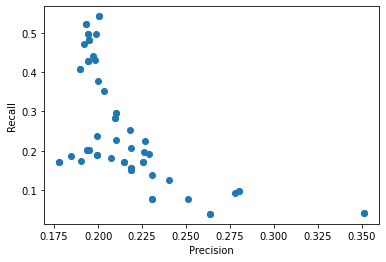

In [27]:
# Get the mean test precision and precision from optimized_dt.cv_results_
# and plot a scatter plot.

# Write your code here
# ---------------------------------------------------------

# Get the average precision from the validation sets in cross validation
mean_test_precision = optimized_dt.cv_results_['mean_test_precision']
mean_test_recall = optimized_dt.cv_results_['mean_test_recall']

# Plot precision and recall as a scatter plot
plt.scatter(mean_test_precision, mean_test_recall)
plt.xlabel('Precision');
plt.ylabel('Recall');

# ---------------------------------------------------------

After the grid search you should see that the CART tree performs nearly as well as the best LR_L1 model. However, it seems that if you select the parameters appropriately, you will either swing to high recall or high precision.

You can go through all of the parameters (`params`) and their corresponding precision (`mean_test_precision`) and recall scores (`mean_test_recall`) inside `cv_results_`. Explore the grid search results and answer the following questions.


1. Lets suppose that the "best" model is one that maximizes the sum of mean test recall and mean test precision. What parameters does the "best" model have based on the results from the grid search?


In [28]:
# Write your code here
# -------------------

cv_result_df = pd.DataFrame(optimized_dt.cv_results_)
cv_result_df['mean_test_score'] = cv_result_df['mean_test_recall'] + cv_result_df['mean_test_precision']
highest_mean_score_index = cv_result_df.mean_test_score.argmax()

print(f'The best model has a score of {cv_result_df.mean_test_score.max():.3f}')
print(f'The best model has the parameters {cv_result_df.params.loc[highest_mean_score_index]}')

# -------------------

The best model has a score of 0.742
The best model has the parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 20}


2. Determine the set of parameters that achieved the highest precision and the other set that achieved the highest recall. Do the settings make sense intuitively? 

In [29]:
# Write your code here
# -------------------

'''You can write some code to explore the data below
You should find that setting balanced class weights will help recall.
In general, increasing the minimum samples per leaf improves performance,
and setting no class weights will improve precision. This makes sense since
the dataset is imbalanced and it is often easier to just try to get a few 1's correctly
in order to improve the precision.'''

highest_precision = cv_result_df.params[mean_test_precision.argmax()]
highest_recall = cv_result_df.params[mean_test_recall.argmax()]
print(f'The model with the highest precision had the settings: {highest_precision}\n \
The model with the highest recall had the settings: {highest_recall}')

# -------------------

The model with the highest precision had the settings: {'class_weight': None, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 20}
 The model with the highest recall had the settings: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 20}


In the code below, we choose the parameter settings that maximize the sum of precision and recall, and tested the models on the validation set.

In [30]:
 # Find the model with the highest sum of precision and recall
params = optimized_dt.cv_results_['params']
best_model_params_index = (mean_test_precision + mean_test_recall).argmax()
best_model_params = params[best_model_params_index]

# Initialize the model 
best_model = DecisionTreeClassifier(random_state=0, **best_model_params)
'''Note, the ** from above allows us to use a dictionary to set 
the parameters of a function'''

# Fit the model on the ENTIRE training set 
best_model.fit(X_train, y_train)

# Evaluate model precision, recall, and score
model_precision = precision_score(y_val, best_model.predict(X_val))  # evaluate precision on test set
model_recall = recall_score(y_val, best_model.predict(X_val))  # evaluate recall on test set
model_score = (model_precision + model_recall) / 2

# Add model scores to all_models data frame
all_models.loc['CART', 'Grid Search'] = (model_precision, model_recall, model_score, best_model)
all_models['Score'].loc['CART', ['Baseline', 'Grid Search']]

model names  technique  
CART         Baseline       0.201266
             Grid Search    0.349308
Name: Score, dtype: float64

### Exercises
> 1. Why does precision and recall get worse after training the model on the training set?

>> There is a very slight degree of overfitting in the grid search. Remember that in grid search we do cross validation of different splits on the training data. It is only natural for the model to perform a little bit worse on completely out of sample data.


# Clustering
The goal of clustering is to bin observations from a dataset into groups of similar points. Unlike regression, clustering is a method that does not require samples of the target data in order to train the model. This is known as _unsupervised learning_. Clustering is often used early on in model engineering to create new features. In this lab, you will cluster data and develop regression models that use the cluster labels as a feature.


## Distance metrics
Clusters are formed from points separated by small distances. Note that there are two types of distance in cluster (1) _Intra_-cluster distance is the distance between points within a cluster, and (2) _inter_-cluster distance is the distance between different clusters. Intra-cluster distance is the metric that $k$-means clustering minimizes, however, there are other methods that use both types of distance (e.g., [agglomerative clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering)). The distance is quantified by a chosen _distance measure_ (see Appendix A for a summary of common distance measures).



## $k$-Means clustering

In this lab, we focus on $k$-means clustering, which is a method for assigning each observation in a given dataset to one of $k$ clusters. For example, you may have a data set of $n$ observations that are indexed by $i = 1, 2, 3... n$ with $m$ features that are indexed by $j = 1, 2, 3... m$. Then we can represent each observation as a point in $m$-D space: $\mathbf{x}_i = (x_{i1},x_{i2},...,x_{ij})$. 

$k$-means clustering is a quick and dirty approach to unsupervised learning. It is relatively easy to implement and is generally more efficient than other clustering methods, which makes it useful for large datasets. The main parameter to consider is the number of clusters $k$. The algorithm then finds $k$ optimally-placed cluster centroids. The nearest centroid for a given observation determines the cluster that the observation is binned in.


Finding the optimal cluster centroids is an _NP-hard_ problem, and iterative heuristics are consequently used. The most common iterative heuristics is _Lloyd’s algorithm_, which completes the following steps in each iteration:

1. Assign each point to a cluster, based on the nearest centroid.
2. Shift each cluster centroid to the centroid of the points in the given cluster.

Lloyd’s algorithm relies on an initial set of centroids (initialized by a random number generator). In practice, randomly generated points that are far apart make for a good set of initial centroids. The algorithm should be run several times to find a good set of centroids. 



## Clustering data
Determining the number of clusters to generate often requires exploratory analysis or expert opinion. In simple cases the number of clusters can be intuited once the data is visualized. In general, you should try and play with different numbers of cluster numbers. Use the `KMeans` function to divide the data into 10 separate clusters. Note that you must use the `X_train` for this task.

In [31]:
# Define clustering model 
mdk_k_means = KMeans(n_init = 1,  # number of different centroid seed initializations (number of times algorithm is run)
                   n_clusters=10,  # number of clusters (k)
                   random_state = 0)  # random seed for k-means algorithm

# Fit the model to the training set
mdk_k_means.fit(X_train)

# Get cluster assignments for each data point
clK = mdk_k_means.labels_

# Get the centroid of each cluster
Centroids = mdk_k_means.cluster_centers_

$k$-means clustering tries to identify the optimal placement of the $k$ cluster centroids and bins the data accordingly. The final centroids are saved in the rows of `Centroids`. Complete the following activities:

### Exercise 
1. Identify the cluster that stores the most "educational" loans. Next, change the random state of mdl_k_means to 2. How does changing the random_state effect the cluster with most "educational" loans? Why does this happen?

In [32]:
# Write your code here

# -------------------

## Method 1 
cluster_set = set(clK)
most_education = 0
for c in cluster_set:
    education_sum = X_train.Purpose_educational[c==clK].sum()
    if education_sum > most_education:
        most_education = education_sum
        education_cluster = c

# Method 2 
# Make a series of cluster predictions
train_clusters = pd.Series(clK, name = 'cluster', index=X_train.index)

# Get cluster with most holidays
cluster_df = X_train.join(train_clusters).groupby('cluster').sum()
education_cluster = cluster_df.Purpose_educational.idxmax()
most_education = cluster_df.Purpose_educational.max()

'''The number of education loans in the cluster with the most education loans
 changes because of random chance'''

print('At most {:.3f} education was assigned to cluster {:.0f}.'.format(most_education,education_cluster))

# -------------------

At most 171.000 education was assigned to cluster 0.


2. Change the n_init to 50 to run the algorithm 50 times. Compare the `inertia_` attribute of this new model to that of the first clustering model `mdk_k_means`. Why do you think it improved? (**Hint**: Inertia is the sum of squared intra-cluster distances). 



In [33]:
# Write your code here

# -------------------

previous_inertia = mdk_k_means.inertia_

# Define clustering model 
mdk_k_means_new = KMeans(n_init = 50, n_clusters=10, random_state = 0)  # random seed for k-means algorithm
mdk_k_means_new.fit(X_train)
new_inertia = mdk_k_means_new.inertia_

'''The model improved because we're taking the best one from the 50 that 
are run (rather than just the best one of one).'''

print(f'The inertia improved by {(previous_inertia/new_inertia - 1) * 100:.2f}%')

# -------------------

The inertia improved by 5.46%


In the examples above we arbitrarily set the number of clusters $k$ to 10, however, there are tricks to choosing the right $k$. One common heurstic for choosing the number of clusters is the _elbow method_ (details [here](https://predictivehacks.com/k-means-elbow-method-code-for-python/)), but it's a little contriversial. However, since we're planning to use the clusters as a feature in a model (i.e., stacking, which is discussed in the next section), the best thing to do is to see what number of clusters achieves the best score in the resulting stacked model.





# Ensembles
Ensemble methods combine the knowledge from multiple models to achieve better performance than any of the constituent models could achieve alone. 




## Stacking multiple models

Stacking is a type of ensemble model that passes the predictions from one or more models as input to another prediction model. In a stacked model, we train a series of *different* prediction models on the dataset. Each of those simple models will predict a target that is then used as a feature(s) for another downstream model. 

In general, the initial models should do most of the work learning from the data. However, the final model will be able to use those results, and learn when one predictive model is more appropriate than another. `sklearn` actually has a function `StackingClassifier` for stacking models (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)). However, we provide an example of stacking that doesn't use `StackingClassifier` so that we can one-hot-encode the cluster numbers.  

Let's create a set of four stacked models that end with our four baseline models and start with a clustering model. 

In [34]:
'''A stacked model that begins with clustering'''
technique_name = 'Stacking'

# Initialize the clustering model
model = KMeans(n_init=10, n_clusters=8, random_state=0)
model.fit(X_train)

# Stack training data
X_train_prediction = pd.Series(model.predict(X_train), 
                            name='cluster',
                            index=X_train.index)

# One-hot-encode cluster numbers
X_train_prediction = pd.get_dummies(X_train_prediction)
# Add cluster numbers to features
X_train_stacked = X_train.join(X_train_prediction)

# Stack testing data
X_val_prediction = pd.Series(model.predict(X_val),
                             name='cluster',
                             index=X_val.index)
# One-hot-encode cluster numbers
X_val_prediction = pd.get_dummies(X_val_prediction)
# Get cluster numbers that weren't predicted in the testing set
missing_cluster_columns = X_train_prediction.columns.difference(X_val_prediction.columns)
# Add missing cluster dummy variables
X_val_prediction[missing_cluster_columns] = 0 
# Add cluster numbers to features
X_val_stacked = X_val.join(X_val_prediction)

# We will use logistic regression instead of a decision tree at the higher-level classifier
all_models = fit_and_score_model(all_models, technique_name, X_train_stacked, X_val_stacked, y_train, y_val)
compare_models(technique_name)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LR_L2 achieved a precision of 0.000 and recall of 0.000
LR_L1 achieved a precision of 0.260 and recall of 0.589
CART achieved a precision of 0.195 and recall of 0.199
RF achieved a precision of 1.000 and recall of 0.004
On average, scores improved by 0.11, and the most improvement was 0.42


### Exercise 

> 1. Change the number of clusters to maximize the biggest improvement between these models and the baseline models. How many clusters do you think we should use in this stacking model?

>> 8 seems to be the best

## Bagging Models
Bagging is another type of ensemble model that passes the prediction from one or more models as input to a _voting rule_. For example, random forests are an bagging model that is constructed from a family of simple decision trees. Random forests (and ensemble methods in general) work on the assumption that most decision trees will predict well, and they define a simple voting rule (e.g., majority rule) to convert the predictions from several models into a single prediction. Similar to stacking, `sklearn` has a function `VotingClassifer` for bagging models (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html))

Throughout this lab we have found that some models clearly performed better than others on both precision and recall. However, even if the average score of one model is less than another, that model may still be better at predicting for certain subsets and scenarios. This is where the idea of ensembles comes in. Below, we use the `VotingClassifer` to fit a bagging model. Note, that we 'weight' the predictions of each model using the model's score, to give better models more sway (i.e., votes) than worse models. 

In [35]:
# from sklearn.ensemble import VotingClassifier
technique_name = 'Bagging'

# Get a list of initialized models for bagging
models_dict = make_models()
# Convert models to list of tuples (required by documentation)
model_list = list(models_dict.items()) 

# Set the weights for each model as their relative performance
bagging_weights = all_models.Score[:,'Baseline'].values

# Initialize bagging model
bagging_model = VotingClassifier(model_list, weights=bagging_weights)
# Fit the bagging model (i.e., each of the four models that are bagged)
bagging_model.fit(X_train.values, y_train.values)

# Predict the target using the bagged model
bagging_prediction = bagging_model.predict(X_val)

# Evaluate ensemble model
model_precision = precision_score(y_val,  bagging_prediction)  # evaluate precision on validation set
model_recall = recall_score(y_val,  bagging_prediction)  # evaluate recall on validation set
model_score = (model_precision + model_recall) / 2

# Add ensemble model to all_models dataframe
all_models.loc[:, technique_name, :] = (model_precision, model_recall, model_score, None) 
compare_models(technique_name)

On average, scores improved by 0.24, and the most improvement was 0.42


### Exercises

> 1. You should see that this model was no better than the best model from the set of baselines. Why do you think that bagging all of these models was no better than the best of the constituent models?

>> We bagged several low quality models

> 2. Code up the bagging model above without using the `VotingClassifier`. You predictions should be identical to what we see above. 

In [36]:
# Write your code here

# -------------------

# Define list of models in ensemble
ensemble_models_df = all_models.loc[:, ['Baseline'], :]
ensemble_models = ensemble_models_df.Model

# Make the weights for the voting rule
ensemble_weighting = ensemble_models_df.Score / ensemble_models_df.Score.sum()

# Initialize a numpy array of zeros of hold predictions
y_preds = np.zeros((len(y_val), len(ensemble_models)))

# Loop through each model and make prediction of the validation set
for model_idx, model in enumerate(ensemble_models):
  y_preds[:, model_idx] = model.predict(X_val) * ensemble_weighting[model_idx]

# Take the highest prediction to be the prediction of the ensemble 
ensemble_prediction = np.round(y_preds.sum(axis=1))

# Evaluate ensemble model
model_precision = precision_score(y_val,  ensemble_prediction)  # evaluate precision on validation set
model_recall = recall_score(y_val,  ensemble_prediction)  # evaluate recall on validation set
model_score = (model_precision + model_recall) / 2

# Add ensemble model to all_models data frame
all_models.loc[:, 'Bagging', :] = (model_precision, model_recall, model_score, None) 
compare_models('Bagging')

# -------------------


On average, scores improved by 0.24, and the most improvement was 0.42


# Analyzing the performance of all models

Lets finish up by looking at the `all_models` data frame. 

### Exercise

> 1. What model achieved the highest recall, the highest precision, and the highest score?  



In [37]:
# Write your code here
# -------------------

# Get the models with the best precision, recall, and score
best_models = all_models[['Precision',	'Recall',	'Score']].idxmax()
# Return the values 
all_models.loc[best_models]

# -------------------

,,Precision,Recall,Score,Model
model names,technique,,,,
RF,Stacking,1.000000,0.004193,0.502096,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
LR_L1,Feature Engineering,0.259191,0.591195,0.425193,"LogisticRegression(C=1.0, class_weight='balanc..."
RF,Stacking,1.000000,0.004193,0.502096,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."


> 2. Think about your application. Which models are useful? Are there certain models that are definitively better than others? 

>> The model that achieve high recall (LR_L1 with	Feature Engineering) is likely the best in this application. The stacked RF model performed a very well on the score because it achieved perfect precision (i.e., no false positives), however, that model only predicted that 2 people failed to repay their loan, which misses 475 other people who failed to repay. 

# Closing comments
In the end, there are very few rules in terms of what you should and shouldn't do when model engineering. Model engineering is more of an art than a science. Keep in mind that a method that works really well for one application may not work at all for another.  You can add new components in the stack, grid search to find better parameters of the top model, hunt for new features, and train different models on different subsets of data (e.g., bagging/bootstrap). It's even possible to train your models on the prediction errors of other models (e.g., boosting). 

# Appendix A: Distance measures

Let $\mathbf{x} = (x_1,x_2,\dots,x_n)$ and $\mathbf{y} = (y_1,y_2,\dots,y_n)$ be two observations. A distance metric is defined as a function $d(\mathbf{x},\mathbf{y})$, that satisfies the following criteria:

1. __Non-negativity:__ $d(\mathbf{x},\mathbf{y}) \geq 0$ and $d(\mathbf{x},\mathbf{y}) = 0 \Rightarrow \mathbf{x} = \mathbf{y}$.
2. __Symmetry:__ $d(\mathbf{x},\mathbf{y}) = d(\mathbf{y},\mathbf{x})$.
3. __Triangle inequality:__ $d(\mathbf{x},\mathbf{y}) + d(\mathbf{y},\mathbf{z}) \geq d(\mathbf{x},\mathbf{z})$.

Any distance metric can be used for clustering. Moreover, metric-like functions that satisfy some of the constraints---often ignoring the triangle inequality---are also used in practice. In this section, we summarize several commonly used distance functions. Custom distance functions can also be used, however, for most purposes those contained in `pdist` are sufficient.

1. __Euclidean (i..e, $l_2$ distance):__ the standard notion of distance that we are most familiar with:
    $$ d(\mathbf{x},\mathbf{y}) = \sqrt{\sum_{i=1}^n (x_i - y_i)^2}.$$
    
2. __Mahalanobis:__ intuitively tries to account for distortions in the data by normalizing with the covariance. Let $K_{i,j}$ be the $i^th$ and $j^{th}$ covariance matrix. Then, the Mahalanobis distance measures:
    $$d(\mathbf{x},\mathbf{y}) = \sqrt{\sum_{i=1}^n (x_i-y_i)^2 K_{i,j}}.$$
    
3. __Manhattan/Cityblock (i.e., $l_1$ distance):__ sum of the absolute values of distances:
    $$ d(\mathbf{x},\mathbf{y}) = \sum_{i=1}^n | x_i - y_i |.$$

4. __Chebychev (i.e., $l_\infty$ distance):__ largest distance of a single feature:
    $$ d(\mathbf{x}, \mathbf{y}) = \max_{i} | x_i - y_i |.$$

5. __Minkowski (i.e., $l_p$ distance):__ a generalization of Euclidean, Manhattan, and Chebyshev:
    $$ d(\mathbf{x},\mathbf{y}) = \sqrt[p]{\sum_{i=1}^n |x_i - y_i|^p}.$$

6. __Hamming:__ the number of different features between the two vectors:
    $$ d(\mathbf{x},\mathbf{y}) = \sum_{i=1}^n \mathbb{I}(x_i \neq y_i).$$
    